In [1]:
# %matplotlib notebook
import requests
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
from scipy.interpolate import UnivariateSpline
import pandas as pd
import numpy as np
from pathlib import Path
import os
import glob
from astropy.units import Magnitude

In [2]:
class ZTF_fake_LC(object):    
    def __init__(self, object_name, ZTF_cad_name, input_folder='../data/fakes/input', rnd_seed=0):
        self.object_name = object_name
        self.ZTF_cad_name = ZTF_cad_name
        if not (object_name.startswith('flat') or object_name.startswith('step') or object_name.startswith('delta')):
            self.data = pd.read_csv(input_folder+'/LC-input/'+self.object_name+'.csv')
            self.time = self.data['mjd'].to_numpy()
            self.mag = self.data['mag'].to_numpy()
#             self.magerr = self.data['magerr']
        self.cad_file = pd.read_csv(input_folder+'/ZTF_cadence/'+self.ZTF_cad_name+'.csv')
        # Select private survey only
        self.time_field = self.cad_file['mjd'][self.cad_file['mjd'] <= 58483.0].to_numpy()
        self.rng = np.random.default_rng(rnd_seed)


    @classmethod
    def from_output(cls, filename):
        path = Path(filename)
        folder_name = path.absolute().parent.name
        basename, _ = os.path.splitext(path.name)
        
        ZTF_cad_name = folder_name
        object_name, smoth_factor, shift, complete_cadence = basename.rsplit('_', maxsplit=3)
        print(object_name, smoth_factor, shift, complete_cadence)
        self = cls(object_name, ZTF_cad_name)
        self.smoth_factor = float(smoth_factor)
        self.complete_cadence = True if complete_cadence == 'True' else False
        self.shift = float(shift)
        
        data = pd.read_csv(filename)
        self.time_field = data['mjd'].to_numpy()
        self.mag_out = data['mag'].to_numpy()
        self.magerr_out = data['magerr'].to_numpy()
        return self
       
    def transform_magn(self, shift=0.0, bias=np.inf):
        shifted = Magnitude(self.mag + shift)
        bias = Magnitude(bias + shift)
        biased_flux = shifted.physical + bias.physical
        biased = Magnitude(biased_flux)
        return biased.value
        
    def generate_fake_LC(self, smoth_factor=0.1, shift=0., k=3, noise=1.0, mag_shift=0.0, bias=np.inf):
        self.shift = shift
        delta_t = self.time_field[0] - self.time[0] + self.shift
        self.time_new = self.time + delta_t
        self.mag_new = self.transform_magn(shift=mag_shift, bias=bias)
        if np.isfinite(bias):
            time_step = 5
            left_time = np.arange(self.time_new[0] - time_step, self.time_field[0] - 2*time_step, -time_step)[::-1]
            left_mag = np.full_like(left_time, bias + mag_shift)
            right_time = np.arange(self.time_new[-1] + time_step, self.time_field[-1] + 2*time_step, time_step)
            right_mag = np.full_like(right_time, bias + mag_shift)
            self.time_new = np.concatenate([left_time, self.time_new, right_time])
            self.mag_new = np.concatenate([left_mag, self.mag_new, right_mag])
        self.spl = UnivariateSpline(self.time_new, self.mag_new, k=k)
        self.time_int = np.linspace(self.time_new.min(axis=0), self.time_new.max(axis=0), num=1000, endpoint=True)
        self.smoth_factor = smoth_factor
        self.spl.set_smoothing_factor(self.smoth_factor)
        if np.min(self.time_field)> np.min(self.time_new) and  np.max(self.time_field)< np.max(self.time_new):
            self.complete_cadence = True
        else :
            self.complete_cadence = False
            Filtre = np.ones(len(self.time_field), dtype = bool)
            for i, t  in enumerate(self.time_field):
                if t < np.min(self.time_new) or t > np.max(self.time_new):
                    Filtre[i] = False
            self.time_field = self.time_field[Filtre]
        print(self.complete_cadence)  
        mag = self.spl(self.time_field)
        self.magerr_out = 0.0297 * mag - 0.4179
        self.magerr_out[self.magerr_out < 0.001] = 0.001
        self.mag_out = self.rng.normal(loc=mag, scale=self.magerr_out * noise)
    
    def generate_flat_fake_LC(self, mag_input=17., noise=1.0):
        self.smoth_factor = 0
        self.shift = 0
        self.complete_cadence = True
        mag = np.full_like(self.time_field, mag_input)
        self.magerr_out = 0.0297 * mag - 0.4179
        self.mag_out = self.rng.normal(loc=mag, scale=self.magerr_out * noise)

    def generate_step_fake_LC(self, mag_bias=20.0, mag_step=15.0, duration=0.3, position_center=0.5, noise=1.0):
        self.smoth_factor = 0
        self.shift = 0
        self.complete_cadence = True
        mag = np.full_like(self.time_field, mag_bias)
        left_bound, right_bound = (
            self.time_field[0]
            + np.array([position_center - duration/2, position_center + duration/2])
            * (self.time_field[-1] - self.time_field[0])
        )
        mag[(self.time_field > left_bound) & (self.time_field < right_bound)] = mag_step
        self.magerr_out = 0.0297 * mag - 0.4179
        self.mag_out = self.rng.normal(loc=mag, scale=self.magerr_out * noise)
        
    def generate_delta_fake_LC(self, mag_bias=20., mag_delta=15.0, position=0.5, noise=1.0):
        self.smoth_factor = 0
        self.shift = 0
        self.complete_cadence = True
        mag = np.full_like(self.time_field, mag_bias)
        peak_idx = np.searchsorted(self.time_field, (self.time_field[0] + self.time_field[-1]) / 2)
        mag[peak_idx] = mag_delta
        self.magerr_out = 0.0297 * mag - 0.4179
        self.mag_out = self.rng.normal(loc=mag, scale=self.magerr_out * noise)
        
    def visualise_intet_fit(self): 
        plt.plot(self.time_int, self.spl(self.time_int), 'b', lw=2, label='UniSpl') # interpolation
        plt.title(self.object_name)
        plt.errorbar(self.time_field, self.mag_out, yerr=self.magerr_out,
                     linestyle='', marker='.',color='black', label='data_out')
        plt.errorbar(self.time_new, self.mag_new,  linestyle='',
                     color='orange', marker='.', label='data_in')
        plt.vlines(self.time_field, *plt.ylim(), lw=0.5, ls='--', label='field cadence')
        plt.gca().invert_yaxis()
        plt.legend(loc='best')
        plt.show()
        plt.close()
        
    def plot_fake_LC(self, figsize=(6,5), output_folder='../figs/fakes/'):
        fig = plt.figure(figsize=figsize)
        plt.title(self.object_name)
        plt.errorbar(self.time_field, self.mag_out, yerr=self.magerr_out, 
                     linestyle='', marker='.',color='black', 
                     label= 'smoth factor = '+str(self.smoth_factor)+'\nshift = '+str(self.shift))
        plt.xlabel('mjd', fontsize=10)
        plt.ylabel('mag', fontsize=10)
        plt.gca().invert_yaxis()
        plt.legend()
        plt.savefig(output_folder+self.ZTF_cad_name +'/'+self.object_name+'_'+str(self.smoth_factor)+'_'+str(self.shift)+'_'+str(self.complete_cadence)+'.png')   
        plt.show()
        plt.close()
        
    def write_output(self, output_folder='../data/fakes/output/'):
        d = {'mjd': self.time_field, 'mag': self.mag_out, 'magerr': self.magerr_out, 'clrcoeff': None}
        df = pd.DataFrame(data=d)
        df.to_csv(output_folder+ self.ZTF_cad_name+'/'+self.object_name+'_'+str(self.smoth_factor)+'_'+str(self.shift)+'_'+str(self.complete_cadence)+'.csv')          
        
    def extract_features(self):
        light_curve = [dict(t=t, m=m, err=err) for t, m, err in zip(self.time_field, self.mag_out, self.magerr_out)]
        resp = requests.post('http://features.lc.snad.space/', json=dict(light_curve=light_curve))
        resp.raise_for_status()
        self.features = resp.json()
    

def write_features(fakes, names, output_folder='../data/fakes/output', suffix='_m31_fake'):
    if isinstance(names, str):
        with open(names) as fh:
            names = fh.read().split()
    oid = np.memmap(os.path.join(output_folder, 'oid' + suffix + '.dat'), mode='w+',
                    dtype=np.uint64, shape=len(fakes))
    dtype = [(name, np.float32) for name in names]
    feature = np.memmap(os.path.join(output_folder, 'feature' + suffix + '.dat'), mode='w+',
                        dtype=dtype, shape=len(fakes))
    for i, fake in enumerate(fakes):
        oid[i] = i
        for name, value in fake.features.items():
            feature[name][i] = value
    df = pd.DataFrame(data=[fake.object_name for fake in fakes], index=oid)
    df.to_csv(os.path.join(output_folder, 'fakes' + suffix + '.csv'))

# Generate fake LC from files

True


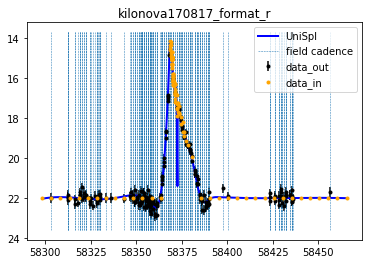

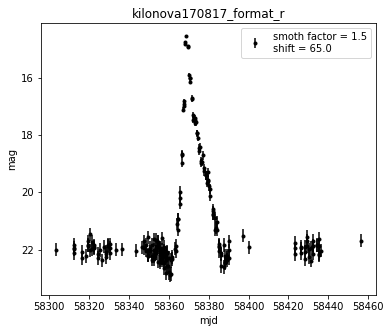

True


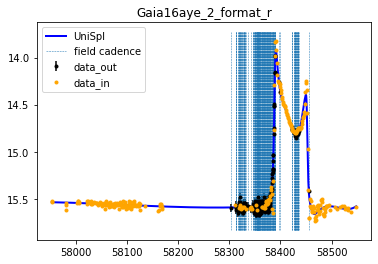

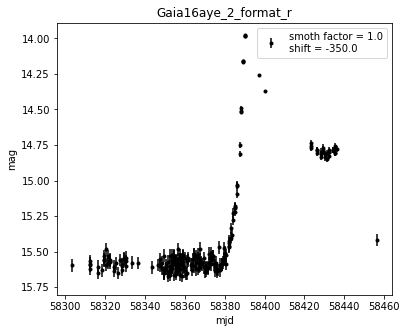

True


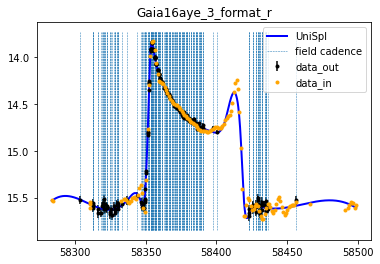

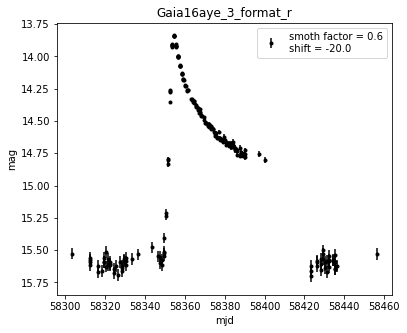

False


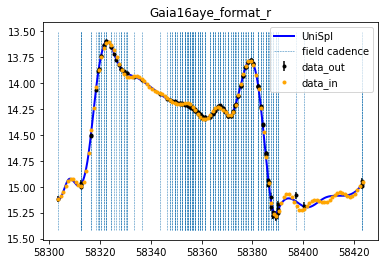

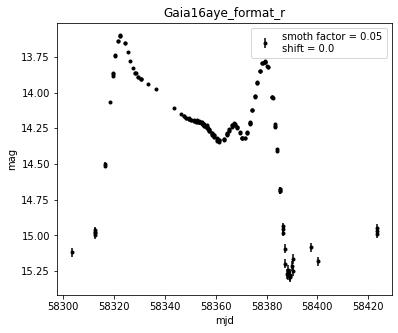

True


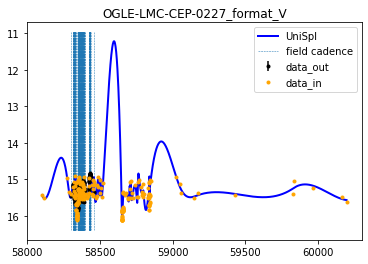

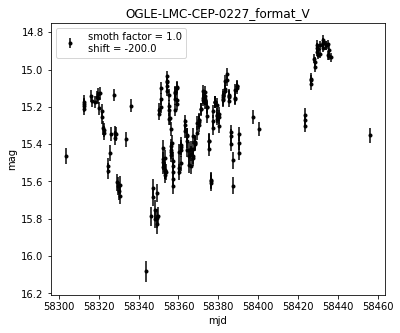

True


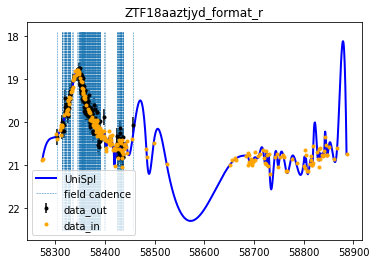

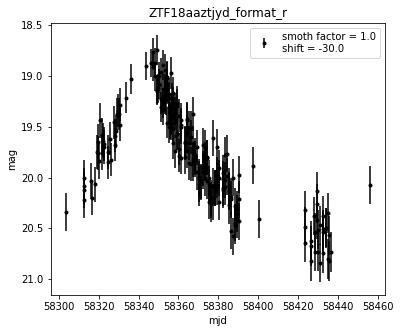

True


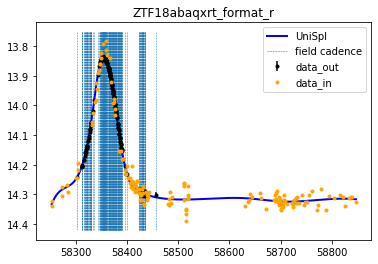

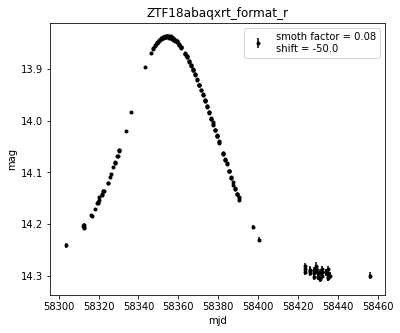

True


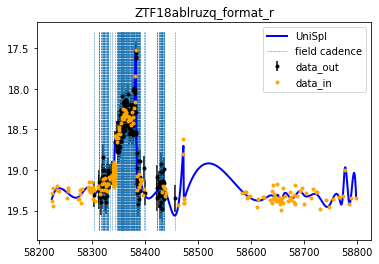

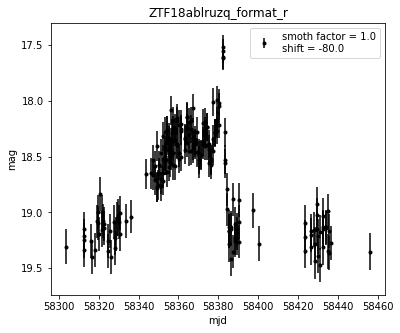

True


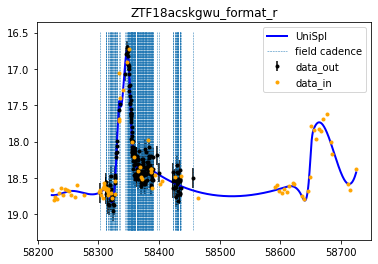

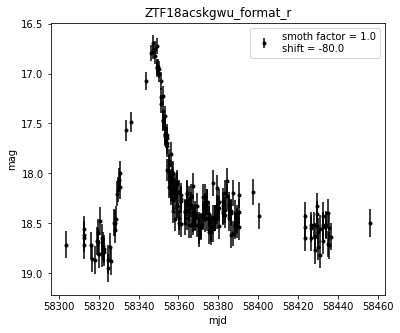

True


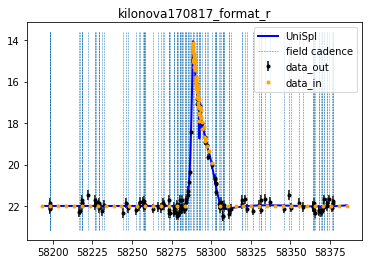

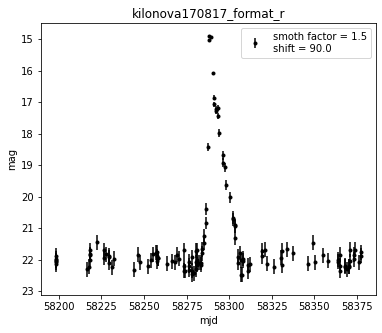

True


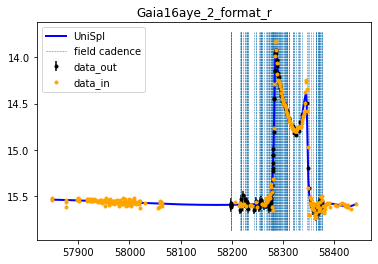

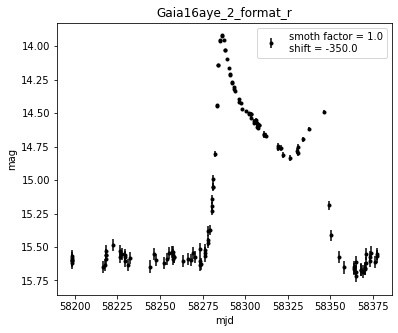

True


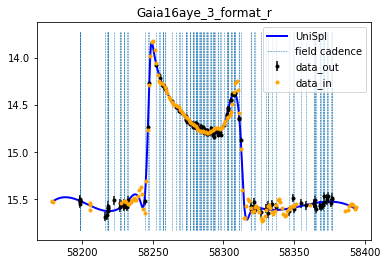

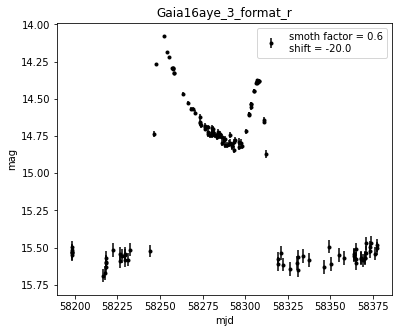

False


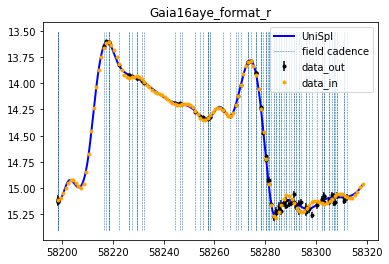

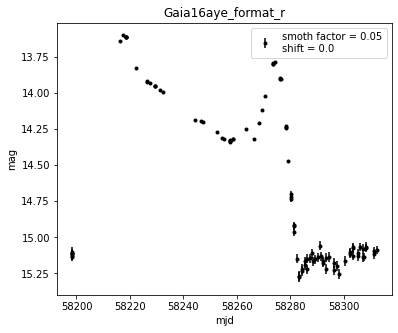

True


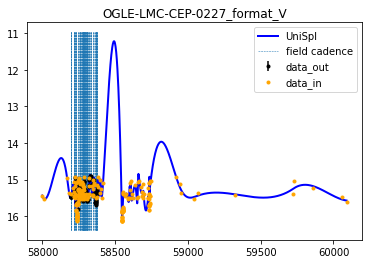

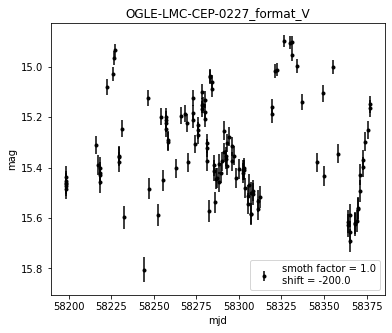

False


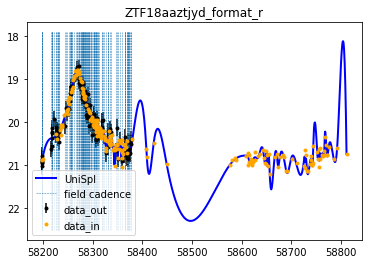

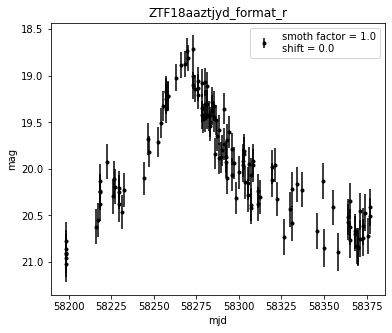

True


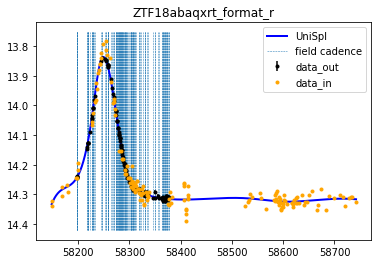

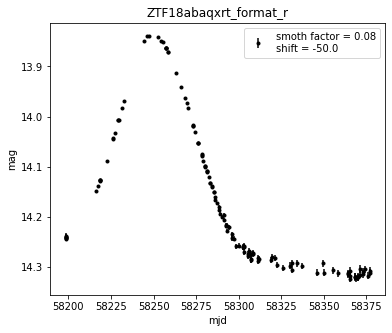

True


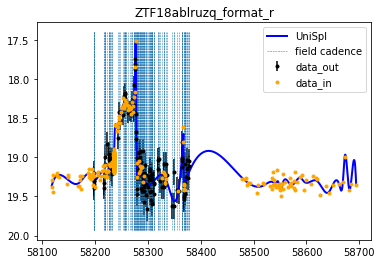

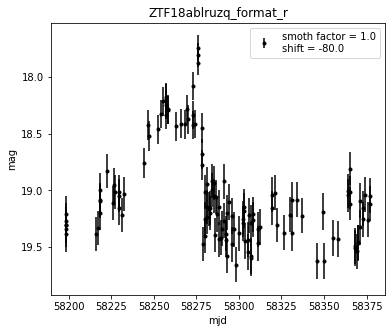

True


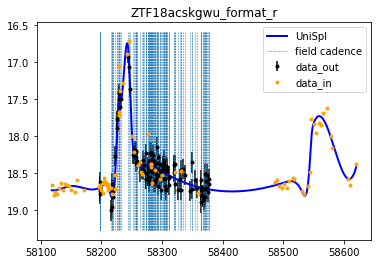

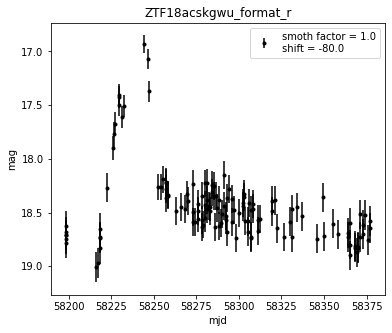

True


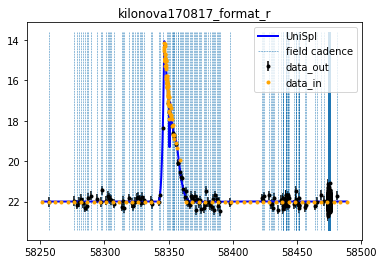

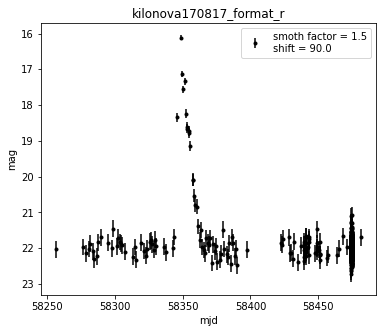

True


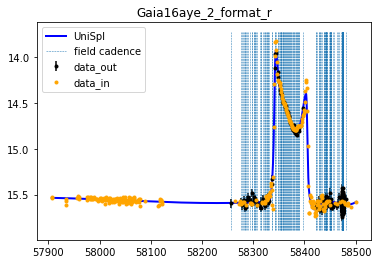

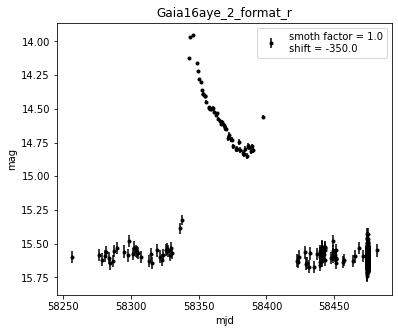

False


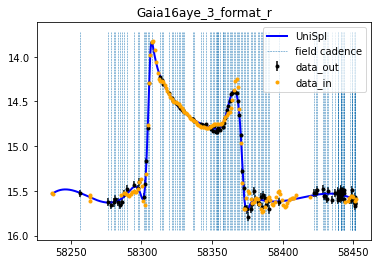

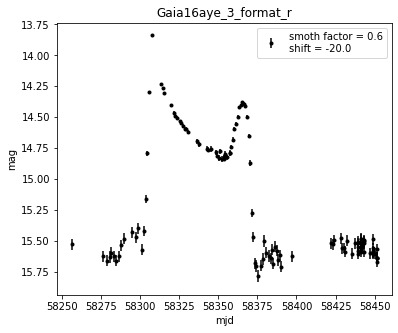

False


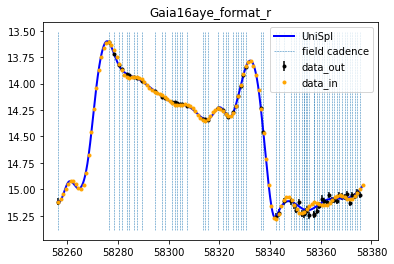

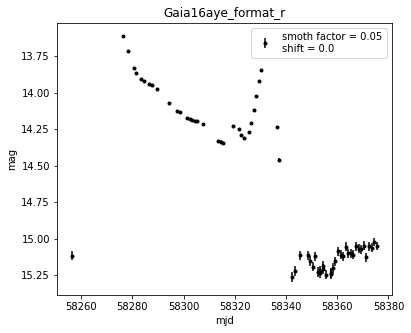

True


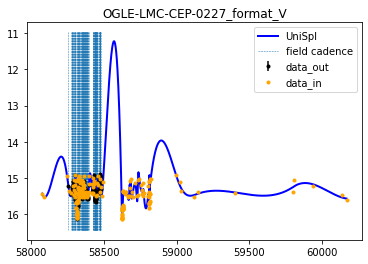

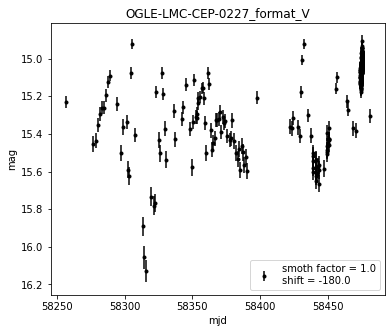

False


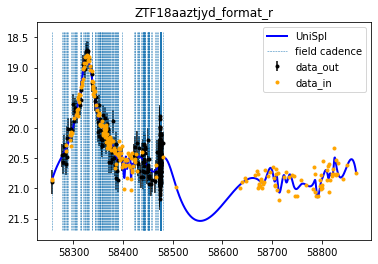

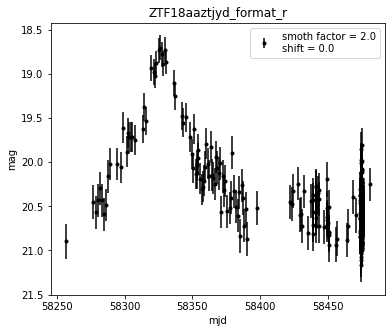

True


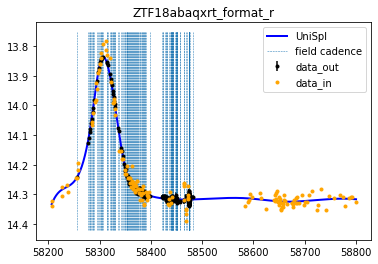

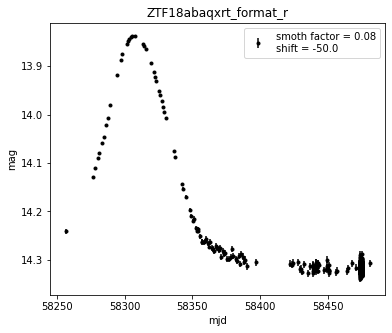

True


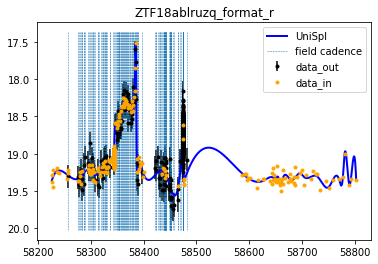

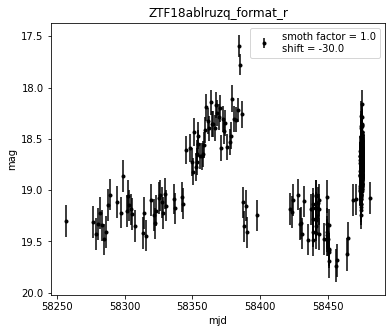

True


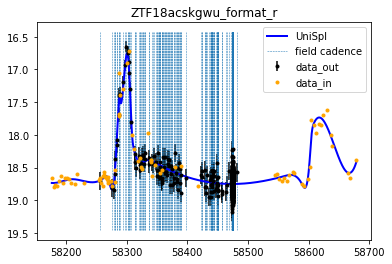

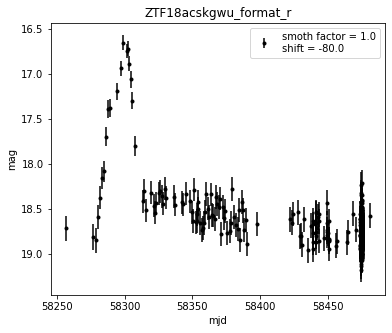

In [3]:
for field, fake, smooth_factor, shift, mag_shift, bias in [
    ('FID695', 'kilonova170817_format_r', 1.5, 65.0, -3.0, 25),
    ('FID695', 'Gaia16aye_2_format_r', 1.0, -350.0, 0.0, np.inf),
    ('FID695', 'Gaia16aye_3_format_r', 0.6, -20.0, 0.0, np.inf),
    ('FID695', 'Gaia16aye_format_r', 0.05, 0.0, 0.0, np.inf),
    ('FID695', 'OGLE-LMC-CEP-0227_format_V', 1.0, -200.0, 0.0, np.inf),
    ('FID695', 'ZTF18aaztjyd_format_r', 1.0, -30.0, 0.0, np.inf),
    ('FID695', 'ZTF18abaqxrt_format_r', 0.08, -50.0, 0.0, np.inf),
    ('FID695', 'ZTF18ablruzq_format_r', 1.0, -80.0, 0.0, np.inf),
    ('FID695', 'ZTF18acskgwu_format_r', 1.0, -80.0, 0.0, np.inf),
   
    ('FID795', 'kilonova170817_format_r', 1.5, 90.0, -3.0, 25),
    ('FID795', 'Gaia16aye_2_format_r', 1.0, -350.0, 0.0, np.inf),
    ('FID795', 'Gaia16aye_3_format_r', 0.6, -20.0, 0.0, np.inf),
    ('FID795', 'Gaia16aye_format_r', 0.05, 0.0, 0.0, np.inf),
    ('FID795', 'OGLE-LMC-CEP-0227_format_V', 1.0, -200.0, 0.0, np.inf),
    ('FID795', 'ZTF18aaztjyd_format_r', 1.0, 0.0, 0.0, np.inf),
    ('FID795', 'ZTF18abaqxrt_format_r', 0.08, -50.0, 0.0, np.inf),
    ('FID795', 'ZTF18ablruzq_format_r', 1.0, -80.0, 0.0, np.inf),
    ('FID795', 'ZTF18acskgwu_format_r', 1.0, -80.0, 0.0, np.inf),
    
    ('FID807', 'kilonova170817_format_r', 1.5, 90.0, -3.0, 25),
    ('FID807', 'Gaia16aye_2_format_r', 1.0, -350.0, 0.0, np.inf),
    ('FID807', 'Gaia16aye_3_format_r', 0.6, -20.0, 0.0, np.inf),
    ('FID807', 'Gaia16aye_format_r', 0.05, 0.0, 0.0, np.inf),
    ('FID807', 'OGLE-LMC-CEP-0227_format_V', 1.0, -180.0, 0.0, np.inf),
    ('FID807', 'ZTF18aaztjyd_format_r', 2.0, 0.0, 0.0, np.inf),
    ('FID807', 'ZTF18abaqxrt_format_r', 0.08, -50.0, 0.0, np.inf),
    ('FID807', 'ZTF18ablruzq_format_r', 1.0, -30.0, 0.0, np.inf),
    ('FID807', 'ZTF18acskgwu_format_r', 1.0, -80.0, 0.0, np.inf),
]:
    ztf_fake = ZTF_fake_LC(fake, field)
    ztf_fake.generate_fake_LC(
        smoth_factor=smooth_factor,
        shift=shift,
        mag_shift=mag_shift,
        bias=bias,
    )
    ztf_fake.visualise_intet_fit()
    ztf_fake.plot_fake_LC()
    ztf_fake.write_output()

# Generate fake Flat LC

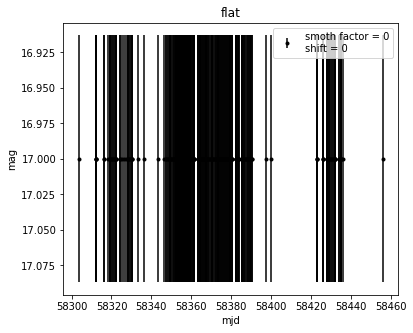

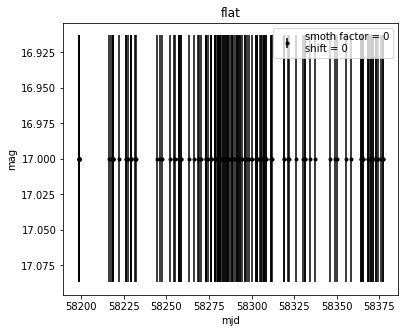

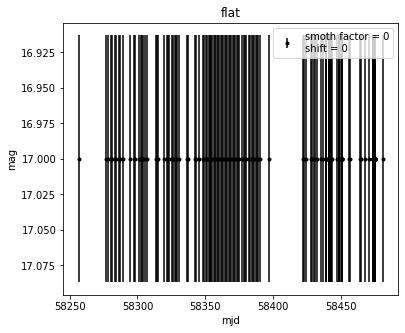

In [4]:
for field in ('FID695', 'FID795', 'FID807'):
    ztf_fake = ZTF_fake_LC('flat', field)
    ztf_fake.generate_flat_fake_LC(mag_input=17., noise=0.0)
    ztf_fake.plot_fake_LC()
    ztf_fake.write_output()

# Generate fake Flat Noise LC

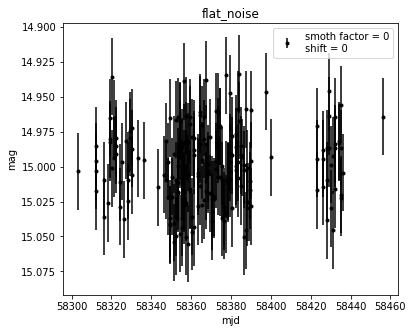

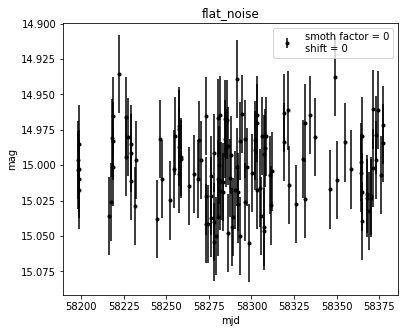

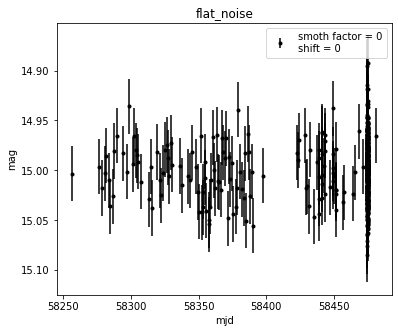

In [5]:
for field in ('FID695', 'FID795', 'FID807'):
    ztf_fake = ZTF_fake_LC('flat_noise', field)
    ztf_fake.generate_flat_fake_LC(mag_input=15., noise=1.0)
    ztf_fake.plot_fake_LC()
    ztf_fake.write_output()

# Generate fake Step Noise LC

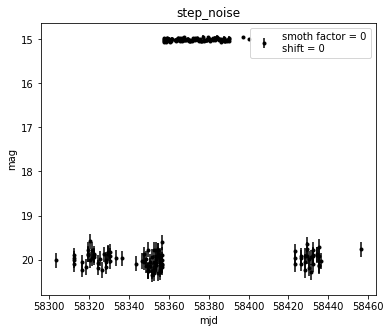

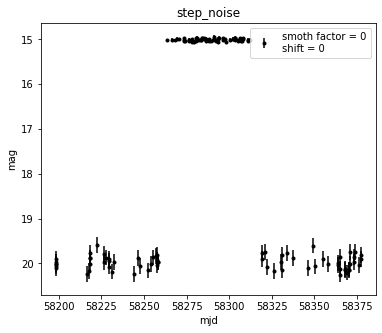

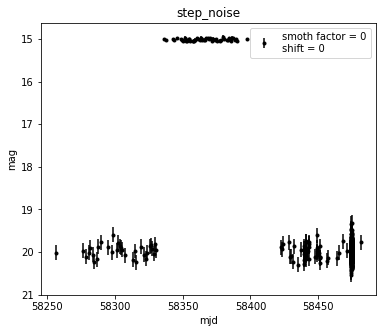

In [6]:
for field in ('FID695', 'FID795', 'FID807'):
    ztf_fake = ZTF_fake_LC('step_noise', field)
    ztf_fake.generate_step_fake_LC(mag_bias=20.0, mag_step=15.0, noise=1.0)
    ztf_fake.plot_fake_LC()
    ztf_fake.write_output()

# Generate fake Step Noise LC

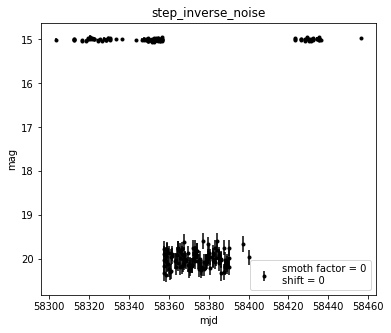

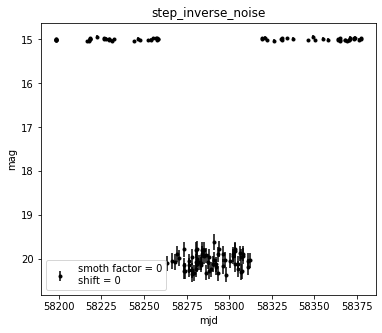

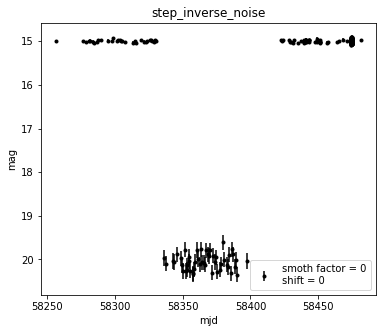

In [7]:
for field in ('FID695', 'FID795', 'FID807'):
    ztf_fake = ZTF_fake_LC('step_inverse_noise', field)
    ztf_fake.generate_step_fake_LC(mag_bias=15.0, mag_step=20.0, noise=1.0)
    ztf_fake.plot_fake_LC()
    ztf_fake.write_output()

# Generate fake Delta Noise LC

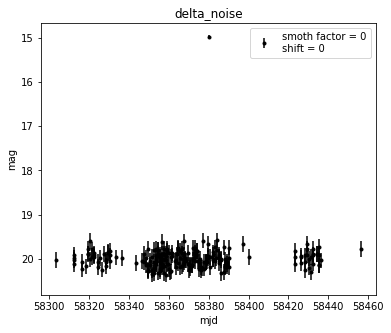

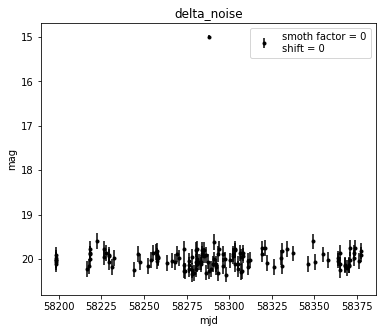

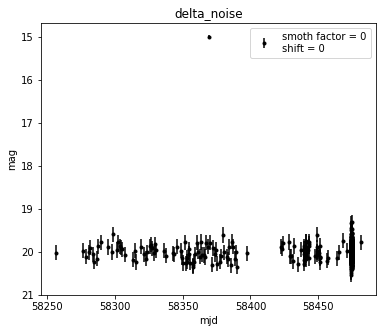

In [8]:
for field in ('FID695', 'FID795', 'FID807'):
    ztf_fake = ZTF_fake_LC('delta_noise', field)
    ztf_fake.generate_delta_fake_LC(mag_bias=20.0, mag_delta=15.0, noise=1.0)
    ztf_fake.plot_fake_LC()
    ztf_fake.write_output()

# Generate fake Delta Inverse Noise LC

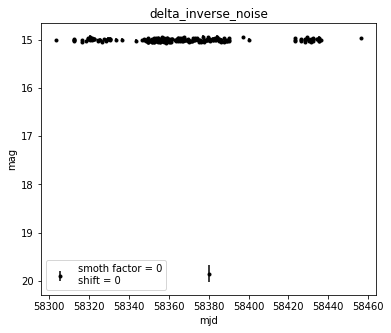

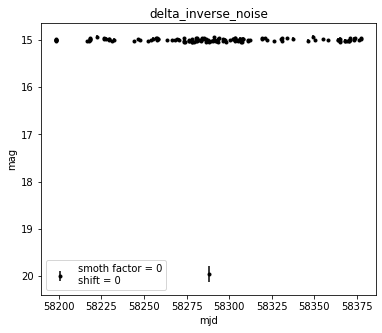

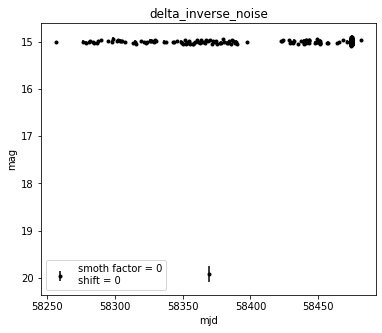

In [9]:
for field in ('FID695', 'FID795', 'FID807'):
    ztf_fake = ZTF_fake_LC('delta_inverse_noise', field)
    ztf_fake.generate_delta_fake_LC(mag_bias=15.0, mag_delta=20.0, noise=1.0)
    ztf_fake.plot_fake_LC()
    ztf_fake.write_output()

# Feature files

In [10]:
def generate_features_for_filed(field_folder, field_name):
    fakes = []
    for file in sorted(glob.glob(os.path.join(field_folder, '*csv'))):
        fake = ZTF_fake_LC.from_output(file)
        fake.extract_features()
        fakes.append(fake)
    write_features(
        fakes,
        names='../data/feature_{}.name'.format(field_name),
        output_folder='../data/fakes/',
        suffix='_{}_fake'.format(field_name)
    )
                           
generate_features_for_filed('../data/fakes/output/FID695/', 'm31')
generate_features_for_filed('../data/fakes/output/FID795/', 'deep')
generate_features_for_filed('../data/fakes/output/FID807/', 'disk')

Gaia16aye_2_format_r 1.0 -350.0 True
Gaia16aye_3_format_r 0.6 -20.0 True
Gaia16aye_format_r 0.05 0.0 False
OGLE-LMC-CEP-0227_format_V 1.0 -200.0 True
ZTF18aaztjyd_format_r 1.0 -30.0 True
ZTF18abaqxrt_format_r 0.08 -50.0 True
ZTF18ablruzq_format_r 1.0 -80.0 True
ZTF18acskgwu_format_r 1.0 -80.0 True
delta_inverse_noise 0 0 True
delta_noise 0 0 True
flat 0 0 True
flat_noise 0 0 True
kilonova170817_format_r 1.5 65.0 True
step_inverse_noise 0 0 True
step_noise 0 0 True
Gaia16aye_2_format_r 1.0 -350.0 True
Gaia16aye_3_format_r 0.6 -20.0 True
Gaia16aye_format_r 0.05 0.0 False
OGLE-LMC-CEP-0227_format_V 1.0 -200.0 True
ZTF18aaztjyd_format_r 1.0 0.0 False
ZTF18abaqxrt_format_r 0.08 -50.0 True
ZTF18ablruzq_format_r 1.0 -80.0 True
ZTF18acskgwu_format_r 1.0 -80.0 True
delta_inverse_noise 0 0 True
delta_noise 0 0 True
flat 0 0 True
flat_noise 0 0 True
kilonova170817_format_r 1.5 90.0 True
step_inverse_noise 0 0 True
step_noise 0 0 True
Gaia16aye_2_format_r 1.0 -350.0 True
Gaia16aye_3_format_r 0.6 -